In [1]:
# !pip install gym

In [2]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import os

In [3]:
DEFAULT_RANDOM_SEED = 2021

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seedEverything(2021)

In [4]:
# ---------------------------
# Custom Environment
# ---------------------------
class TabularClassificationEnv(gym.Env):
    def __init__(self, df):
        super(TabularClassificationEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.current_index = 0

        # Action space: two actions (0 and 1)
        self.action_space = gym.spaces.Discrete(2)
        # Observation space: features (assumes label is dropped)
        num_features = df.shape[1] - 1
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(num_features,), dtype=np.float32)

    def reset(self):
        self.current_index = 0
        return self._get_observation()

    def step(self, action):
        if self.current_index >= len(self.df):
            return self._get_observation(), 0.0, True, {}

        # Retrieve the true label; assumes column name 'label'
        true_label = self.df.iloc[self.current_index]['label']

        # Modified reward structure:
        # If the sample is positive (label == 1), reward correctly.
        # Penalize misclassification more severely.
        if action == true_label:
            reward = 2.0 if true_label == 0 else 1.0
        else:
            reward = -3.0 if true_label == 1 else -1.0

        self.current_index += 1
        done = self.current_index >= len(self.df)
        if done:
            return self._get_observation(), reward, done, {}
        else:
            return self._get_observation(), reward, done, {}

    def _get_observation(self):
        if self.current_index < len(self.df):
            row = self.df.iloc[self.current_index]
            if 'label' in self.df.columns:
                obs = row.drop('label').values.astype(np.float32)
            else:
                obs = row.values[:-1].astype(np.float32)
            return obs
        else:
            return np.zeros(self.observation_space.shape, dtype=np.float32)

In [5]:
# ---------------------------
# Q-Network Definition
# ---------------------------
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_sizes=(32, 32)):
        super(QNetwork, self).__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [6]:
# ---------------------------
# DQN Agent
# ---------------------------
class DQNAgent:
    def __init__(self, obs_dim, action_dim, hidden_sizes=(32, 32), lr=1e-3,
                 gamma=0.99, epsilon=0.1, device='cpu'):
        self.q_net = QNetwork(obs_dim, action_dim, hidden_sizes).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_dim = action_dim
        self.device = device

    def select_action(self, state):
        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_net(state_tensor)
        return q_values.argmax().item()

    def train_step(self, batch):
        # Unpack a batch of transitions
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Compute current Q-values for taken actions
        q_values = self.q_net(states).gather(1, actions)
        # Compute the next state's maximum Q-value
        next_q_values = self.q_net(next_states).max(1)[0].unsqueeze(1)
        # Compute TD target
        target = rewards + self.gamma * next_q_values * (1 - dones)
        loss = F.mse_loss(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

In [7]:
# ---------------------------
# Simple Replay Buffer
# ---------------------------
class ReplayBuffer:
    def __init__(self):
        self.buffer = []

    def add(self, transition):
        self.buffer.append(transition)

    def clear(self):
        self.buffer = []

    def sample_all(self):
        return self.buffer.copy()

    def __len__(self):
        return len(self.buffer)

In [8]:
# ---------------------------
# Training Function
# ---------------------------
def train_agent(agent, env, replay_buffer, num_iterations=1000, batch_size=32, verbose=True):
    state = env.reset()
    print("Training...")
    for i in range(num_iterations):
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.add((state, action, reward, next_state, float(done)))
        state = next_state
        if done:
            state = env.reset()

        # Train only if we have enough samples in the buffer
        if len(replay_buffer) >= batch_size:
            # Sample a mini-batch randomly from the replay buffer
            batch = random.sample(replay_buffer.buffer, batch_size)
            loss = agent.train_step(batch)
            if i % 100 == 0 and verbose:
                  print(f"Iteration {i}, Loss: {loss}")


In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def test_agent(agent, env):
    # Set epsilon to 0 for deterministic behavior during testing
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0

    state = env.reset()
    total_reward = 0
    correct_predictions = 0
    total_predictions = 0
    y_true = []
    y_pred = []
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # After calling step, the environment index is incremented.
        # This allows us to get the true label corresponding to the state from which the action was taken.
        idx = env.current_index - 1 if env.current_index > 0 else 0
        true_label = env.df.iloc[idx]['label']

        y_true.append(true_label)
        y_pred.append(action)

        if action == true_label:
            correct_predictions += 1
        total_predictions += 1

        state = next_state

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    false_positive_rate = FP / (FP + TN) if (FP + TN) > 0 else 0.0

    print(f"Total Reward: {total_reward}, Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"False Positive Rate: {false_positive_rate}")

    # Restore the original epsilon
    agent.epsilon = original_epsilon


In [16]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your DataFrame
df = pd.read_csv('train.csv')

In [17]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [18]:
# Split into training and testing sets (67% train, 33% test)
X = df.drop('label',axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=DEFAULT_RANDOM_SEED)

scaler = joblib.load("scaler.pkl")

features = scaler.feature_names_in_

X_train = X_train[features]
X_test = X_test[features]



X_train_scaled = pd.DataFrame(
    scaler.transform(X_train),
    columns=scaler.feature_names_in_,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=scaler.feature_names_in_,
    index=X_test.index
)

train_df = pd.concat([X_train_scaled, y_train], axis=1)
test_df = pd.concat([X_test_scaled,  y_test], axis=1)

train_df.drop('Unnamed: 0',axis=1,inplace=True)
test_df.drop('Unnamed: 0',axis=1,inplace=True)

In [19]:
train_df.head(10)

,destination port,flow duration,total fwd packets,total backward packets,total length of fwd packets,total length of bwd packets,fwd packet length max,fwd packet length min,fwd packet length mean,fwd packet length std,...,min_seg_size_forward,active mean,active std,active max,active min,idle mean,idle std,idle max,idle min,label
122187,-0.450119,-0.472707,-0.008392,-0.010497,-0.048563,-0.007846,-0.302041,-0.216322,-0.293055,-0.264807,...,0.003078,-0.137240,-0.109002,-0.159062,-0.111073,-0.374857,-0.118537,-0.380956,-0.360507,1
21200,-0.450119,1.957032,-0.001356,-0.005251,-0.020714,-0.002297,0.223950,-0.318046,-0.093994,0.191130,...,0.003078,-0.134478,-0.109002,-0.157307,-0.107931,3.054045,-0.118537,2.944582,3.104955,1
39120,-0.450119,2.812439,0.008493,0.003142,-0.018222,-0.007489,0.262863,-0.318046,-0.183643,0.102085,...,0.003078,-0.073093,-0.036078,-0.031574,-0.053901,0.027003,-0.115252,0.008907,0.043712,0
146434,-0.430945,-0.451270,0.005679,0.002093,0.013291,-0.005834,0.095136,-0.318046,-0.006408,0.066852,...,0.003086,-0.137240,-0.109002,-0.159062,-0.111073,-0.374857,-0.118537,-0.380956,-0.360507,0
163865,-0.430945,1.524404,0.135131,0.184656,0.891407,0.040620,1.443660,-0.318046,0.296755,0.472662,...,0.003086,5.105353,2.800507,3.983156,4.400033,0.815854,0.578395,0.866875,0.745972,0
179485,-0.451545,-0.471893,-0.012613,-0.010497,-0.047243,-0.007782,-0.253735,0.394023,-0.108782,-0.264807,...,0.003086,-0.137240,-0.109002,-0.159062,-0.111073,-0.374857,-0.118537,-0.380956,-0.360507,0
65474,-0.450119,-0.469583,-0.012613,-0.009448,-0.049882,-0.007843,-0.302041,-0.216322,-0.293055,-0.264807,...,0.003078,-0.137240,-0.109002,-0.159062,-0.111073,-0.374857,-0.118537,-0.380956,-0.360507,0
147988,-0.090875,-0.473215,-0.011206,-0.009448,-0.050028,-0.007840,-0.307408,-0.284138,-0.313530,-0.264807,...,0.003080,-0.137240,-0.109002,-0.159062,-0.111073,-0.374857,-0.118537,-0.380956,-0.360507,0
114790,-0.451545,-0.472543,-0.011206,-0.009448,-0.044312,-0.007758,-0.255077,0.377069,-0.113901,-0.264807,...,0.003086,-0.137240,-0.109002,-0.159062,-0.111073,-0.374857,-0.118537,-0.380956,-0.360507,0
4454,-0.450119,2.903077,0.482682,0.460599,0.849194,0.419142,0.838501,-0.318046,-0.145787,0.286260,...,0.003086,0.327795,2.200749,2.883566,-0.074732,0.035164,-0.103559,0.016705,0.044787,0


In [20]:
# Create training and testing environments
train_env = TabularClassificationEnv(train_df)
test_env = TabularClassificationEnv(test_df)

# Get observation and action dimensions from the training environment
obs_dim = train_env.observation_space.shape[0]
action_dim = train_env.action_space.n

# Instantiate the DQN Agent and Replay Buffer
agent = DQNAgent(obs_dim, action_dim, hidden_sizes=(128, 128), lr=0.001,
                 gamma=0.99, epsilon=0.1, device='cpu')
replay_buffer = ReplayBuffer()

In [21]:
# Train the agent on the training environment
train_agent(agent, train_env, replay_buffer, num_iterations=4000, verbose=False)

# Test the agent on the testing environment
test_agent(agent, test_env)

Training...
Total Reward: 67900.0, Accuracy: 0.9500792199878123
Precision: 0.8171844323824922
Recall: 0.9383370905715422
F1 Score: 0.8735802469135803
False Positive Rate: 0.04727631107394577


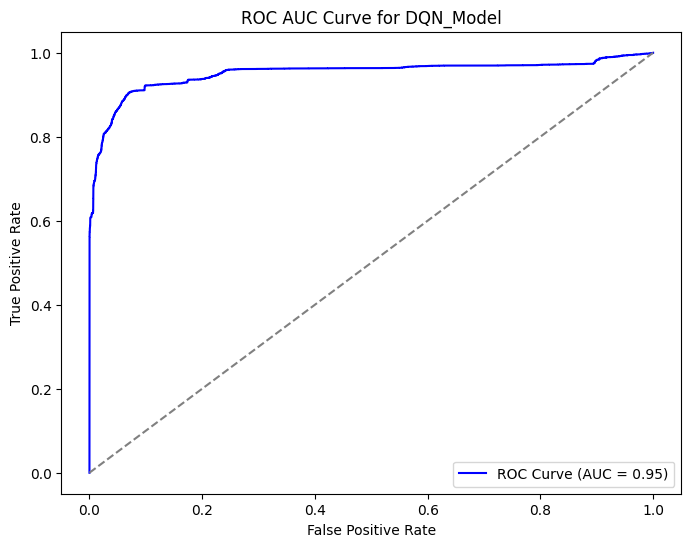

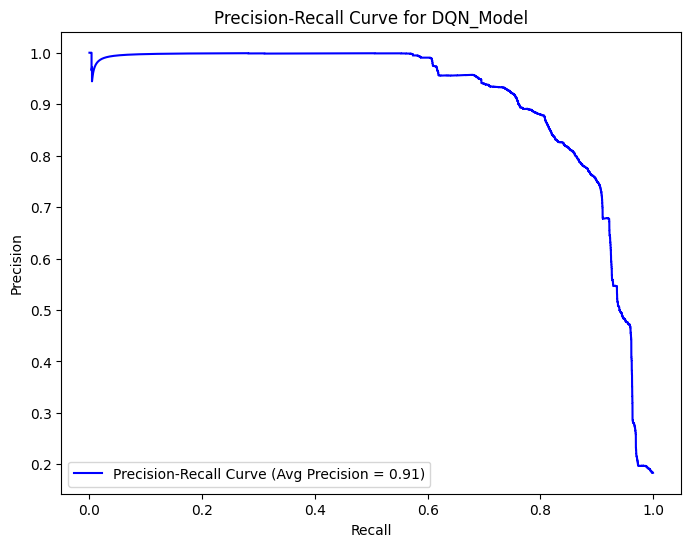

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


model_name = "DQN_Model"

# Gather a 'score' for each sample in test_df by using Q-value for action=1
y_true = []
scores = []  # We'll treat Q-value(action=1) as the confidence for label=1

# Force deterministic (no epsilon)
agent.epsilon = 0.0
with torch.no_grad():
    for i in range(len(test_df)):
        row = test_df.iloc[i]
        label = row['label']
        # Extract features
        state = row.drop('label').values.astype(np.float32)

        # Get Q-values
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = agent.q_net(state_tensor)

        # Score = Q-value for action=1
        score_for_class1 = q_values[0, 1].item()

        y_true.append(label)
        scores.append(score_for_class1)

y_true = np.array(y_true)
scores = np.array(scores)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, scores)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC AUC Curve for {model_name}')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, scores)
avg_precision = average_precision_score(y_true, scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue',
         label=f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve for {model_name}')
plt.legend(loc='lower left')
plt.show()

In [23]:
torch.save(agent.q_net.state_dict(), "dqn_model.pth")
print("Model saved as dqn_model.pth")

Model saved as dqn_model.pth
